In [1]:
import tensorflow.keras as keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import expand_dims, nn

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from numpy import array, split
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Dropout, Reshape, Permute, Activation
from keras.layers import Convolution2D, MaxPooling3D, ConvLSTM2D
from keras.layers.recurrent import LSTM  
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
import keras.callbacks
import os, random

In [3]:
#Load NSW data
x = pd.read_csv("xmat.csv").values
#h = pd.read_csv("hmat.csv").values
eta = pd.read_csv("etamat.csv").values
#Q = pd.read_csv("Qmat.csv").values
P = pd.read_csv("Pmat.csv").values*1000000
u = pd.read_csv("umat.csv").values
#v = pd.read_csv("vmat.csv").values

# Load difference between NSW and Bouss
Pdiff = pd.read_csv("Pdiff.csv").values
Pdiff=Pdiff*100
etadiff = pd.read_csv("etadiff.csv").values

data = np.stack((x,eta,u,P), axis = 2)
#diff = np.stack((Pdiff,etadiff), axis = 2)

(1, 301, 4)
(301,)


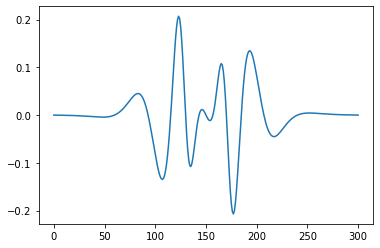

In [24]:
X, y = list(), list()
length = int(data.shape[0]/4)
# how many time steps to predict the next time step
n = 1

for i in range(length):
  end = i + n
  if end > length - 1:
    break

  seq_x, seq_y = data[i:end, :, :], Pdiff[end, :]
  X.append(seq_x)
  y.append(seq_y)

from sklearn.utils import shuffle
X, y = shuffle(X, y)

print(np.shape(X[0]))
print(np.shape(y[0]))
plt.plot(y[5])
plt.show()

In [25]:
# split training and testing
ratio = 0.8
len_train = int(round(length * ratio))
len_test = length - len_train

X_train = X[0:len_train]
y_train = y[0:len_train]
X_test = X[len_train:]
y_test = y[len_train:]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(np.shape(X_train[0]))
print(np.shape(y_train[0]))

(1, 301, 4)
(301,)


## Define CNN
- L2 regularization of 1e-5
- Relu activation on conv2D layers, zero padding as specified in assignment

In [26]:
def CNN(width = 301, features = 4):

  model = Sequential([
    tf.keras.layers.InputLayer([1,width,features]),
    #Convolution layer with 32 (3 ×3) filters, zero padding and ReLU activation
    layers.Conv2D(2000,
        (3,3),
        activation="tanh",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv0"),

    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(256,
        (3,3),
        activation="tanh",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1"),

    layers.MaxPooling2D((2,2), padding='same'),

    # Convolution layer with 128 (3 ×3) filters, zero padding and ReLU activation.
    layers.Conv2D(256,
        (3, 3),
        activation="tanh",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"),

    layers.MaxPooling2D((2,2), padding='same'),

    layers.Flatten(),
    # A fully connected layer with 256 neurons and ReLU activation.
    layers.Dense(256, activation='tanh', kernel_regularizer=keras.regularizers.l2(.001)),

    # A final fully connected layer with width = number of classes = 10 and no activation.
    layers.Dense((301), kernel_regularizer=keras.regularizers.l2(.001))
    ])
  
  opt = tf.keras.optimizers.Adam() #learning_rate=.01)
  model.compile(optimizer=opt,
            loss=keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

## Train Network

In [27]:
model = CNN()
model.summary()

# Batch size = 64, epochs = 20
history = model.fit(X_train, y_train, epochs=100, batch_size=20, shuffle = True, validation_split=.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv0 (Conv2D)              (None, 1, 301, 2000)      74000     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 151, 2000)     0         
 2D)                                                             
                                                                 
 Conv1 (Conv2D)              (None, 1, 151, 256)       4608256   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 76, 256)       0         
 2D)                                                             
                                                                 
 Conv2 (Conv2D)              (None, 1, 76, 256)        590080    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 38, 256)      

Text(0, 0.5, 'Accuracy')

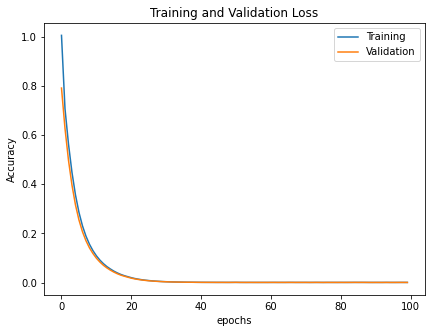

In [50]:
acc = history.history['loss']
val_acc = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Accuracy')


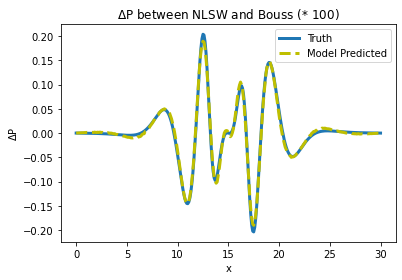

In [31]:
import matplotlib.pyplot as plt

y_predict = model.predict(X_test[100:101], verbose=0)
x = pd.read_csv("xmat.csv").values

plt.plot(x[0,:],np.ndarray.flatten(y_test[100,:]), linewidth=3, label = 'Truth') # y_test[:][1],
plt.plot(x[0,:],np.ndarray.flatten(y_predict[0]),'y--',linewidth = 3,label = 'Model Predicted') # y_predict[:,1],
plt.title('$\Delta$P between NLSW and Bouss (* 100)')
plt.xlabel('x')
plt.ylabel('$\Delta$P')
plt.legend()
plt.show()

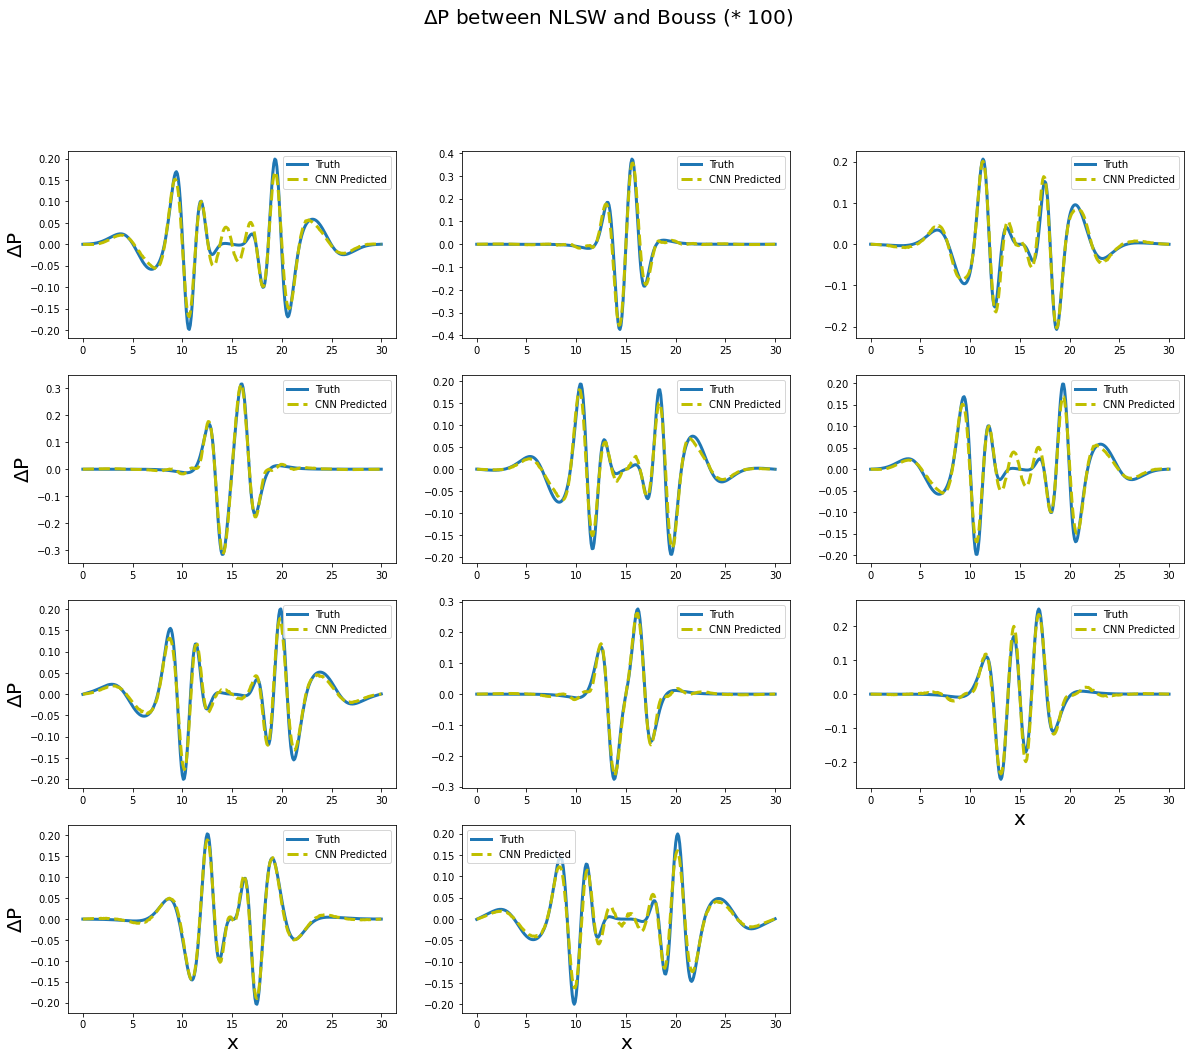

In [49]:
y_predict = model.predict(X_test[0:201], verbose=0)
x = pd.read_csv("xmat.csv").values

plt.figure(figsize=(20, 20))
for i in range(1, 12):
    plt.subplot(5, 3, i)
    plt.plot(x[0,:],np.ndarray.flatten(y_test[i*10,:]), linewidth=3, label = 'Truth') # y_test[:][1],
    plt.plot(x[0,:],np.ndarray.flatten(y_predict[i*10]),'y--',linewidth = 3,label = 'CNN Predicted') # y_predict[:,1],
    plt.suptitle('$\Delta$P between NLSW and Bouss (* 100)', size=20)
    if i in [1,4,7,10]:
        plt.ylabel('$\Delta$P', size=20)
    if i in [9,10,11,12]:
        plt.xlabel('x', size=20)
    plt.legend()

plt.show()

## Test Model